## Compare Binomial & Multinomial Logistic Regression

> Written by Jess Breda September 2023 post lab meeting

A question that came up (from Carlos) was if the mutli-class model would do better on L/R trials if it was trained on L,R,V. The goal of this notebook is to implement this comparison.

**Initial Steps**:

[ ] working with simulated data, figure out the dimensions of the multi-class cost

* follow up questions here if needed

[ ] working with simulated data, create a binomial class for fitting (from prev code)

[ ] validate binomial class finds athena/nick like results with base regressors

*  start with single animal, then expand

[ ] see what prev_violation regressor does for binomial model

[ ] figure out how to make train/test split for the models
	
* follow up if diff number of training trials might be an issue

* probably don't want to make this perfect now, but long term good to think about & have this information easily stored
		
[ ] determine what the null model comparison would be (if any?)


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import pathlib
import sys
from scipy.optimize import minimize

[
    sys.path.append(str(folder))
    for folder in pathlib.Path("../src/").iterdir()
    if folder.is_dir()
]
from get_rat_data import *

### Dimensions of multi-class cost

In the test eval of the cost function, I want to squash out the third dimension so the model performs better. Eg [1/3 1/3 1/3] should become [1/2 1/2] (or [1/2 1/2 0], not sure yet). Need to focus on figuring out the cost code.

In [114]:
class MultiClassLogisticRegressionComp:
    def __init__(self, sigma=None, method="BFGS", disp=True):
        self.W = None
        self.sigma = sigma
        self.method = method
        self.disp = disp

    def fit(self, X: pd.DataFrame, Y: np.ndarray):
        N, D_w_bias = X.shape
        _, C = Y.shape
        initial_W_flat = np.zeros(D_w_bias * C)

        result = minimize(
            fun=self.cost,
            x0=initial_W_flat,
            args=(X.to_numpy(), Y, self.sigma),
            method=self.method,
            jac=self._gradient,
            options={"disp": self.disp},
        )

        self.W = result.x.reshape(D_w_bias, C)
        return self.W

    def eval(self, X: pd.DataFrame, Y: np.ndarray):
        return self.cost(self.W, X.to_numpy(), Y, sigma=None)

    def cost(self, W, X, Y, sigma, lr_only=False):
        """
        Compute the negative log-likelihood for multi-class
        logistic regression with L2 regularization (or MAP).

        params
        ------
        W : np.ndarray, shape (D + 1, C) or flattened (D+1 * C)
        weight matrix, will be in flattened form if in use
            for minimize() function
        X : pd.DataFrame, shape (N, D + 1)
            design matrix with bias column
        Y : np.ndarray, shape (N, C), where C = 3
            one-hot encoded choice labels for each trial as left,
            right or violation
        sigma : float (default=None)
            standard deviation of Gaussian prior, if None no
            regularization is applied
        lr_only : bool (default=False)
            whether to only consider the first two logits (L and R)
            when computing denominator of softmax

        returns
        -------
        - nll : float
            negative log-likelihood
        """
        if len(W.shape) == 1:
            W = W.reshape(X.shape[1], Y.shape[1])

        logits = X @ W

        # Only consider the first two logits (L and R)
        # when computing denominator of softmax
        if lr_only:
            log_sum_exp_term = self.log_sum_exp_lr(logits)
        else:
            log_sum_exp_term = self.log_sum_exp(logits)

        penalty = (
            (1 / (2 * (sigma**2))) * np.trace(W[1:, :].T @ W[1:, :]) if sigma else 0
        )
        nll = (-np.sum(Y * logits) + np.sum(log_sum_exp_term)) + penalty
        return nll

    def _gradient(self, W, X, Y, sigma):
        """
        Compute the gradient of the negative log-likelihood for
        multi-class logistic regression with L2 regularization (or MAP).

        params
        ------
        W : np.ndarray, shape (D + 1, C) or flattened (D+1 * C)
        weight matrix, will be in flattened form if in use
        for minimize() function
        X : pd.DataFrame, shape (N, D + 1)
            design matrix with bias column
        Y : np.ndarray, shape (N, C), where C = 3
            one-hot encoded choice labels for each trial as left,
            right or violation
        sigma : float (default=None)
            standard deviation of Gaussian prior, if None no
            regularization is applied

        returns
        -------
        gradient :  np.ndarray, shape (D+1 * C)
            gradient of the negative log-likelihood

        """
        if len(W.shape) == 1:
            W = W.reshape(X.shape[1], Y.shape[1])

        logits = X @ W
        P = self._stable_softmax(logits)

        if sigma:
            penalty_gradient = W / (sigma**2)
        else:
            penalty_gradient = np.zeros_like(W)

        penalty_gradient[0, :] = 0  # No penalty for bias

        gradient = X.T @ (P - Y) + penalty_gradient
        return gradient.flatten()

    @staticmethod
    def log_sum_exp(logits):
        max_logits = np.max(logits, axis=1, keepdims=True)
        return (
            np.log(np.sum(np.exp(logits - max_logits), axis=1, keepdims=True))
            + max_logits
        )

    @staticmethod
    def log_sum_exp_lr(logits):
        max_logits = np.max(
            logits[:, :2], axis=1, keepdims=True
        )  # Only consider the first two logits (L and R)
        return (
            np.log(np.sum(np.exp(logits[:, :2] - max_logits), axis=1, keepdims=True))
            + max_logits
        )

    @staticmethod
    def stable_softmax(logits):
        exp_logits = np.exp(logits - np.max(logits, axis=1, keepdims=True))
        sum_exp = np.sum(exp_logits, axis=1, keepdims=True)
        return exp_logits / sum_exp

    def generate_data(self, N, D, C, sigma=None, random_state=None):
        """
        Generate data from a multi-class logistic regression
        model with optional L2 regularization (or MAP).

        params
        ------
        N : int
            number of trials/samples
        D : int
            number of features
        C : int
            number of classes
        sigma : float (default=None)
            standard deviation of true weight matrix, if None
            generated with std of 1
        random_state : int (default=None)
            random seed

        returns
        -------
        w : np.ndarray, shape (D + 1, C)
            true weight matrix
        X : pd.DataFrame, shape (N, D + 1)
            design matrix with bias column
        Y : np.ndarray, shape (N, C)
            one-hot encoded choice labels for C classes
        """

        ## Design Matrix
        X = np.random.normal(size=(N, D))
        X = np.c_[np.ones(N), X]  # add bias column

        ## True Weights
        np.random.seed(random_state)
        if sigma:
            W = np.random.normal(loc=0, scale=sigma, size=(D + 1, C))
        else:
            W = np.random.normal(loc=0, scale=1, size=(D + 1, C))

        ## Choice Labels
        A = X @ W  # logits
        P = self.stable_softmax(A)
        Y = np.array([np.random.multinomial(1, n) for n in P])

        print(f"Generated {N} samples with {D} features and {C} classes")
        print(f"W is {W.shape} \nX is {X.shape} \nY is {Y.shape}")
        print(f"W has mean {np.mean(W):.3f} and std {np.std(W):.3f}")

        return W, X, Y

In [164]:
model = MultiClassLogisticRegressionComp(sigma=1)


N = 100000  # Number of samples
D = 4  # Number of features
C = 3  # Number of classes
sigma = 1.3
W, X, Y = model.generate_data(N, D, C, sigma=sigma, random_state=44)

Generated 100000 samples with 4 features and 3 classes
W is (5, 3) 
X is (100000, 5) 
Y is (100000, 3)
W has mean -0.277 and std 1.434


In [165]:
class BinaryLogisticRegression:
    def __init__(self, sigma=None, method="BFGS", disp=True):
        self.w = None
        self.sigma = sigma
        self.method = method
        self.disp = disp

    def fit(self, X, y):
        N, D_w_bias = X.shape
        initial_w = np.zeros(D_w_bias)

        if isinstance(X, pd.DataFrame):
            X = X.to_numpy()

        result = minimize(
            fun=self.cost,
            x0=initial_w,
            args=(X, y, self.sigma),
            method=self.method,
            jac=self._gradient,
            options={"disp": self.disp},
        )

        self.w = result.x
        return self.w

    def eval(self, X: pd.DataFrame, y: np.ndarray):
        return self.cost(self.w, X.to_numpy(), y, sigma=None)

    def cost(self, w, X, y, sigma):
        """
        Compute the negative log-likelihood for binary
        logistic regression with L2 regularization (or MAP).

        params
        ------
        w : np.ndarray, shape (D + 1, )
            weight vector with bias
        X : pd.DataFrame, shape (N, D + 1)
            design matrix with bias column
        y : np.ndarray, shape (N, )
            binary encoded choice labels where 0 is left and
            1 is right
        sigma : float (default=None)
            standard deviation of Gaussian prior, if None no
            regularization is applied

        returns
        -------
        - nll : float
            negative log-likelihood
        """

        logits = X @ w
        if sigma:
            penalty = 1 / (2 * sigma**2) * np.sum(w**2)
        else:
            penalty = 0

        nll = -np.mean(y * logits - np.log(1 + np.exp(logits))) + penalty
        return nll

    def _gradient(self, w, X, y, sigma):
        """
        Compute the gradient of the negative log-likelihood for
        binary logistic regression with L2 regularization (or MAP).

        params
        ------
        w : np.ndarray, shape (D + 1, )
            weight vector with bias
        X : pd.DataFrame, shape (N, D + 1)
            design matrix with bias column
        y : np.ndarray, shape (N, )
            binary encoded choice labels where 0 is left and
            1 is right
        sigma : float (default=None)
            standard deviation of Gaussian prior, if None no
            regularization is applied

        returns
        -------
        gradient :  np.ndarray, shape (D + 1, )
            gradient of the negative log-likelihood

        """
        logits = X @ w
        p = 1 - 1 / (1 + np.exp(logits))

        if sigma:
            penalty_gradient = w / sigma**2
            penalty_gradient[0] = 0  # No penalty for bias
        else:
            penalty_gradient = 0

        gradient = (np.dot(X.T, (p - y)) / len(y)) + penalty_gradient
        return gradient

    @staticmethod
    def sigmoid(z):
        return 1 / (1 + np.exp(-z))

    def generate_data(self, N, D, sigma=None, random_state=None):
        """
        Generate data from a binary logistic regression
        model with optional L2 regularization (or MAP).

        params
        ------
        N : int
            number of trials/samples
        D : int
            number of features
        sigma : float (default=None)
            standard deviation of true weights, if None
            generated with std of 1
        random_state : int (default=None)
            random seed

        returns
        -------
        w : np.ndarray, shape (D + 1, )
            true weight vector
        X : pd.DataFrame, shape (N, D + 1)
            design matrix with bias column
        y : np.ndarray, shape (N, )
            binary encoded choice labels
        """

        ## Design Matrix
        X = np.random.normal(size=(N, D))
        X = np.c_[np.ones(N), X]  # bias column

        ## True Weights
        np.random.seed(random_state)
        if sigma:
            w = np.random.normal(loc=0, scale=sigma, size=(D + 1))
        else:
            w = np.random.normal(loc=0, scale=1, size=(D + 1))

        ## Choice Labels
        a = X @ w  # logits
        p = self.sigmoid(a)  # probabilities
        y = np.random.binomial(1, p)

        print(f"Generated {N} samples with {D} features")
        print(f"w is {w.shape} \nX is {X.shape} \ny is {y.shape}")
        print(f"w has mean {np.mean(w):.3f} and std {np.std(w):.3f}")

        return w, X, y

In [170]:
bmodel = BinaryLogisticRegression(sigma=1)
w, X, y = bmodel.generate_data(100000, 2, sigma=1, random_state=None)

Generated 100000 samples with 2 features
w is (3,) 
X is (100000, 3) 
y is (100000,)
w has mean -0.055 and std 0.829


In [171]:
fit_w = bmodel.fit(X, y)

         Current function value: 0.665414
         Iterations: 1
         Function evaluations: 65
         Gradient evaluations: 53


In [168]:
def plot_weights(true_W, optimized_W):
    fig, ax = plt.subplots(figsize=(6, 4))

    feature_and_bias_labels = np.arange(len(true_W))

    ax.plot(feature_and_bias_labels, true_W, label="true", color="gray", marker="o")
    ax.plot(
        feature_and_bias_labels,
        optimized_W,
        label="optimized",
        color="gray",
        marker="o",
        linestyle="dashed",
    )

    # Set the x-axis tick labels
    _ = ax.set_xticks(feature_and_bias_labels)
    ax.set(xlabel="Feature", ylabel="Weight", title="Recovered Weights")
    ax.legend()

Something weird going on where i cant recover weights given the new class. might need to re-run restart everything and go from there. Not sure why this would differ from binary_logistic_regression() NB. Not due to generating differently but someting with scipy mininimze, it's only evaluating once and the binary log notebook did 13 iterations

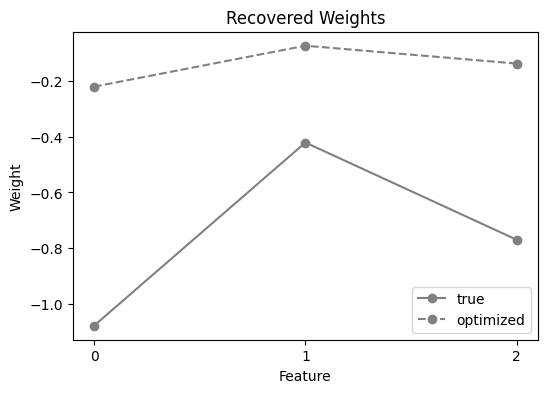

In [169]:
plot_weights(w, fit_w)